In [1]:
"""Test the radiosity.Radiosity module."""
import os

import numpy as np
import pyfar as pf
import sparapy as sp
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
X = 5
Y = 6
Z = 4
patch_size = 0.5
ir_length_s = 2
sampling_rate = 1000
max_order_k = 50
speed_of_sound = 343

absorption = 0.1
S = (2*X*Y) + (2*X*Z) + (2*Y*Z)
A = S*absorption
alpha_dash = A/S
r_h = 1/4*np.sqrt(A/np.pi)
print(f'reverberation distance is {r_h}m')
V = X*Y*Z
RT = 24*np.log(10)/(speed_of_sound)*V/(-S*np.log(1-alpha_dash))
print(f'reverberation time is {RT}s')
# create geometry
walls = sp.testing.shoebox_room_stub(X, Y, Z)
source = sp.geometry.SoundSource([2, 2, 2], [0, 1, 0], [0, 0, 1])

## new approach
radi = sp.radiosity.Radiosity(
    walls, patch_size, max_order_k, ir_length_s,
    speed_of_sound=speed_of_sound, sampling_rate=sampling_rate)



reverberation distance is 0.5426201661567753m
reverberation time is 1.2398651513106647s


/Users/anne/git/_pyfar/sparapy/sparapy/radiosity.py:60: RuntimeWarning: invalid value encountered in divide
  real_size = size/patch_nums


In [3]:
# run simulation
radi.run(source)


100%|██████████| 50/50 [03:14<00:00,  3.88s/it]


In [4]:
# test energy at receiver
receiver_pos = [
    [2, 3, 2], [3, 2, 2], [3, 3, 2], [3, 4, 2],
    [2, 3, 2.5], [3, 2, 2.5], [3, 3, 2.5], [3, 4, 2.5],
    [2, 2, 1.5]
    ]
irs_new = []
for pos in receiver_pos:
    receiver = sp.geometry.Receiver(pos, [0, 1, 0], [0, 0, 1])
    irs_new.append(radi.energy_at_receiver(receiver, ignore_direct=False))
irs_new = np.array(irs_new).squeeze()
reverberation = pf.Signal(irs_new, sampling_rate=sampling_rate)

In [5]:
direct_sound_list = []
direct_analytic = []
for pos in receiver_pos:
    r = np.sqrt(np.sum((np.array(pos)-source.position)**2))
    direct_sound = (1/(4 * np.pi * np.square(r)))
    delay_dir = int(r/speed_of_sound*sampling_rate)
    direct_analytic.append(direct_sound)
    direct_sound_list.append(pf.signals.impulse(
        reverberation.n_samples, delay_dir, direct_sound, sampling_rate).time)
direct_analytic = np.array(direct_analytic)
direct_sound = pf.Signal(
    np.array(direct_sound_list).squeeze(), sampling_rate=sampling_rate)
result = pf.utils.concatenate_channels([reverberation, direct_sound])


In [6]:
E_direct = np.sum(direct_sound.time, axis=-1)
E_reverb = np.sum(reverberation.time, axis=-1)

E_ratio = E_reverb/E_direct

E_direct_analytical = 1/(4*np.pi*r**2)
E_reverb_analytical = 4/A
E_ratio_analytical = E_reverb_analytical/E_direct_analytical

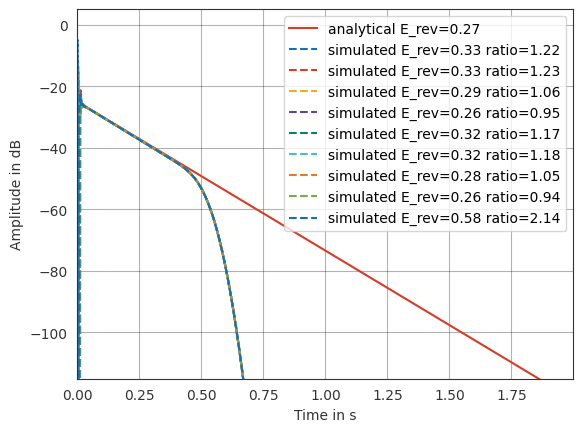

In [7]:
t = reverberation.times
w_0 = E_reverb_analytical/ V # Kuttruff Eq 4.7
t_0 = 0.03
reverberation_analytic = w_0 * np.exp(+(speed_of_sound*S*np.log(1-alpha_dash)/(4*V))*(t-t_0)) # Kuttruff Eq 4.10
reverberation_analytic = pf.Signal(reverberation_analytic, sampling_rate=sampling_rate)
plt.figure()
pf.plot.time(
    reverberation_analytic, dB=True, log_prefix=10,
    label=f'analytical E_rev={E_reverb_analytical:0.2f}', color='r')
for i in range(len(receiver_pos)):
    e_rel = (E_reverb[i]/E_reverb_analytical)
    pf.plot.time(
        reverberation[i], dB=True, log_prefix=10,
        label=f'simulated E_rev={E_reverb[i]:0.2f} ratio={e_rel:0.2f}',
        linestyle='--')
plt.legend()
plt.show()

In [8]:
print(f'E_reverb_analytical: {E_reverb_analytical} == E_reverb: {E_reverb}')
print(f'Ratio: {E_reverb/E_reverb_analytical}')
# print(f'E_direct_analytical: {direct_analytic} == E_direct: {E_direct}')
print(f'Ratio mean: {E_reverb_analytical/np.mean(E_reverb)}')

E_reverb_analytical: 0.27027027027027023 == E_reverb: [0.33072706 0.33343814 0.2875695  0.25610551 0.31515059 0.31782566
 0.28333987 0.25523091 0.57728682]
Ratio: [1.22369013 1.2337211  1.06400716 0.94759038 1.16605718 1.17595493
 1.04835752 0.94435436 2.13596125]
Ratio mean: 0.8226921142120004
